# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Generalized acuteness
## Chapter : Riemannian norms and the Voronoi vectors

This notebook illustrates a construction of acute stencils applicable to two and three dimensional Riemannian metrics. It allows to compute Riemannian distance maps, by solving the corresponding eikonal equations, efficiently in a single pass over the discretization set, using the Fast-Marching method, a Dijkstra-like algorithm. The present notebook is only illustrative, as this algorithms are more efficiently implemented in C++, due to its serial nature.

The stencil construction presented in this notebook is based on the following mathematical tools:
* Voronoi vectors. Those vectors $e\in Z^d \setminus \{0\}$ whose Voronoi cell intersects the Voronoi cell of the origin. 
* The notion of acute angle associated with a scalar product.

Here the scalar product and norm on $R^d$ are associated with a $d\times d$ symmetric positive definite matrix $M$, and defined as follows:
$$
    <u,v>_M := <u,Mv> \qquad \|u\|_M := \sqrt{<u,M u>}
$$

**Comparison with the Stern-Brocot based stencils.**
Another stencil construction is presented in the notebook [SternBrocot](SternBrocot.ipynb). This one distinguishes itself on the following points:
* It only applies to *Riemannian* metric. In constrast, the other construction extends to *Finslerian* metrics.
* It applies in dimension $3$. In constrast, the other construction is limited to dimension two.

**Academic publication.** The contents of this notebooks are related with the following publication:
* Mirebeau, J.-M. (2014). Anisotropic Fast-Marching on cartesian grids using Lattice Basis Reduction. SIAM Journal on Numerical Analysis, 52(4), 1573–1599.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Stencil and acuteness](#1.-Stencil-and-acuteness)
    * [1.1 Two dimensional stencils](#1.1-Two-dimensional-stencils)
    * [1.2 Three dimensional stencils](#1.2-Three-dimensional-stencils)
  * [2. Two dimensional construction](#2.-Two-dimensional-construction)
  * [3. Three dimensional construction](#3.-Three-dimensional-construction)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('VoronoiVectors','Algo'))

In [2]:
from agd.Metrics import Riemann
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import itertools

## 1. Stencil and acuteness

In the context of semi-Lagrangian discretizations of eikonal equations, a stencil at a discretization point $x$ is defined as a polygonal surface enclosing $x$, whose vertices are also discretization points.

We specialize to cartesian grids discretizations, and assume w.l.o.g. that the discretization point considered is the origin. Up to rescaling, the polygonal surface vertices should therefore lie on $Z^d$.
With these conventions the stencil is said *acute*, w.r.t. the scalar product associated to a matrix $M$, iff for any vertices $u,v$ of a common facet of the polygonal surface one has 
$$
    <u,M v> \, \geq 0.
$$

In [4]:
direction2 = [np.cos(np.pi/6),np.sin(np.pi/6)] # Arbitrary non-zero vector
direction3 = [1.5,4.2,10.7] # Arbitrary non-zero vector

In [5]:
aX0 = np.linspace(-1,1); aX1=aX0
X = np.array(np.meshgrid(aX0,aX1,indexing='ij')) # Coordinate system

### 1.1 Two dimensional stencils

We represent two dimensional stencils as a list of vectors. The $4$-element diamond stencil, and $8$-element square stencil are most classical.

In [6]:
e0,e1=np.eye(2)
diamond2 = [e0,e1,-e0,-e1,e0]
box2 = [e0,e0+e1,e1,e1-e0,-e0,-e0-e1,-e1,-e1+e0,e0]

In [7]:
def PlotStencil2(stencil):
    plt.plot(*np.array(stencil).T)
    plt.scatter(*np.array(stencil).T)
    plt.scatter(0,0,color='black')

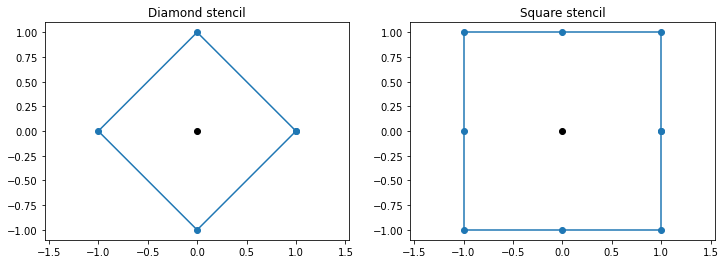

In [8]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.title("Diamond stencil"); plt.axis('equal')
PlotStencil2(diamond2)
plt.subplot(1,2,2)
plt.title("Square stencil"); plt.axis('equal')
PlotStencil2(box2)

We can compute th minimum scalar product between consecutive elements of a stencil.

In [9]:
def MinStencilScal2(stencil,m):
    s = np.array(stencil[:-1]).T
    m=np.expand_dims(m,axis=2)
    return lp.dot_VAV(s,m,np.roll(s,axis=1,shift=1)).min()

Both the diamond and the box stencil are *acute*, a.k.a. the minimal scalar product is non-negative.

In [10]:
MinStencilScal2(diamond2,np.eye(2)), MinStencilScal2(box2,np.eye(2))

(0.0, 1.0)

However, as soon as some non-diagonal anisotropy is introduced, the diamond stencil looses acuteness.
The matrix corresponding to a needle-like Riemannian norm has two eigenspaces: the line spanned by the given direction, and the orthogonal space. The corresponding two eigenvalues are prescribed as parameters.

In [11]:
riemann2_2 = Riemann.needle(direction2,1,2)

In [12]:
MinStencilScal2(diamond2,riemann2_2.m), MinStencilScal2(box2,riemann2_2.m)

(-1.299038105676658, 0.45096189432334155)

The box stencil looses acuteness when anisotropy becomes more pronounced.

In [13]:
riemann2_3 = Riemann.needle(direction2,1,3)

In [14]:
MinStencilScal2(diamond2,riemann2_3.m), MinStencilScal2(box2,riemann2_3.m)

(-3.4641016151377544, -0.4641016151377553)

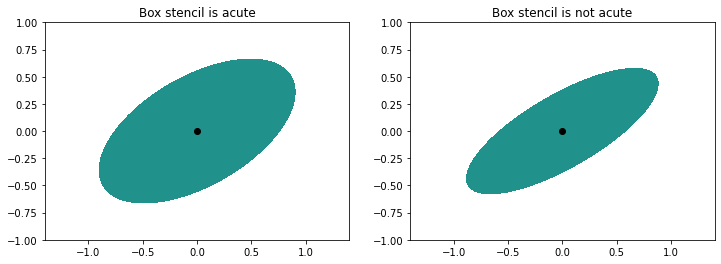

In [15]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.title("Box stencil is acute"); plt.axis('equal')
plt.contourf(*X,riemann2_2.norm(X),levels=[0.,1.]); plt.scatter(0,0,color='black'); 
plt.subplot(1,2,2)
plt.title("Box stencil is not acute"); plt.axis('equal')
plt.contourf(*X,riemann2_3.norm(X),levels=[0.,1.]); plt.scatter(0,0,color='black'); 

### 1.2 Three dimensional stencils

We describe a three dimensional stencil as a set of triangles. The diamond and box stencils admit obvious generalizations, with 8 and 48 triangules respectively.

In [16]:
e0,e1,e2 = np.eye(3)
diamond3 = [[e0*s0,e1*s1,e2*s2] for s0,s1,s2 in itertools.product([-1,1],repeat=3)]
box3 = [ [u*su, u*su+v*sv, u*su+v*sv+w*sw] 
        for u,v,w in itertools.permutations([e0,e1,e2]) 
        for su,sv,sw in itertools.product([-1,1],repeat=3)]

In [17]:
len(diamond3),len(box3)

(8, 48)

In [18]:
def MinStencilScal3(stencil,m):
    def MinFacet(u,v,w):
        return min(lp.dot_VAV(u,m,v),lp.dot_VAV(v,m,w),lp.dot_VAV(w,m,u))
    return min(MinFacet(*s) for s in stencil)

Again, the diamond and box stencils are acute for the isotropic metric.

In [19]:
MinStencilScal3(diamond3,np.eye(3)),MinStencilScal3(box3,np.eye(3))

(0.0, 1.0)

Acuteness of the diamond stencil is immediately lost for non-diagonal anisotropies.

In [20]:
riemann3_2 = Riemann.needle(direction3,1,2)

In [21]:
MinStencilScal3(diamond3,riemann3_2.m),MinStencilScal3(box3,riemann3_2.m)

(-1.0032742967703527, 0.08245274594433738)

Acuteness for the box stencil only holds for very moderate anisotropies.

In [22]:
riemann3_3 = Riemann.needle(direction3,1,3)

In [23]:
MinStencilScal3(diamond3,riemann3_3.m),MinStencilScal3(box3,riemann3_3.m)

(-2.6753981247209406, -1.446792677481767)

## 2. Two dimensional construction

We propose a stencil construction based on the preliminary computation of an $M$-obtuse superbase, see notebook [Selling](TensorSelling.ipynb).
It can be shown that, for generic $M$, the stencil consists of the Voronoi vectors of $Z^2$ for the distance $\|\cdot\|_M$, see the main introduction. 

The stencil is guaranteed to be acute, and to hold no more than $6$ distinct vertices, for any positive definite matrix $M$. This is independent of the condition number of $M$.

In [24]:
def MakeStencil2(m):
    e0,e1,e2 = Selling.ObtuseSuperbase(m).T
    return [e0,-e2,e1,-e0,e2,-e1,e0]

In [25]:
riemann2_5 = Riemann.needle(direction2,1,5)

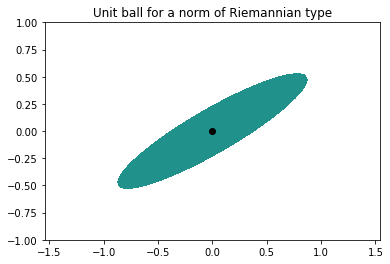

In [26]:
plt.title("Unit ball for a norm of Riemannian type"); plt.axis('equal')
plt.contourf(*X,riemann2_5.norm(X),levels=[0.,1.]); plt.scatter(0,0,color='black'); 

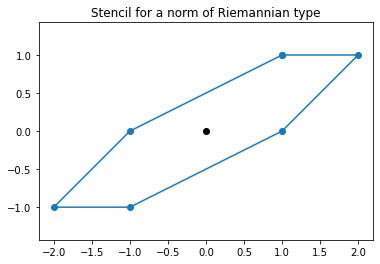

In [27]:
plt.title("Stencil for a norm of Riemannian type"); plt.axis('equal')
PlotStencil2(MakeStencil2(riemann2_5.m)) 

In [28]:
MinStencilScal2(MakeStencil2(riemann2_5.m),riemann2_5.m)

1.8230854637602008

## 3. Three dimensional construction

We propose a stencil construction based on the preliminary computation of an $M$-obtuse superbase, see notebook [Selling](TensorSelling.ipynb).
It can be shown that, for generic $M$, the stencil consists of the Voronoi vectors of $Z^3$ for the distance $\|\cdot\|_M$, see the main introduction. 

The stencil is guaranteed to be acute, and to hold precisely than $14$ distinct vertices and $24$ facets, for any positive definite matrix $M$. This is independent of the condition number of $M$.

In [29]:
def MakeStencil3(m):
    e0,e1,e2,e3 = Selling.ObtuseSuperbase(m).T
    return [(u,u+v,u+v+w) for u,v,w in itertools.permutations([e0,e1,e2,e3],3)]

In [30]:
riemann3_5 = Riemann.needle(direction3,1,5)

In [31]:
MinStencilScal3(MakeStencil3(riemann3_5.m),riemann3_5.m)

1.078434290817091

In [32]:
MakeStencil3(riemann3_5.m)

[(array([ 0., -1., -2.]), array([-1., -1., -3.]), array([ 0.,  0., -1.])),
 (array([ 0., -1., -2.]), array([-1., -1., -3.]), array([-1., -1., -2.])),
 (array([ 0., -1., -2.]), array([1., 0., 0.]), array([ 0.,  0., -1.])),
 (array([ 0., -1., -2.]), array([1., 0., 0.]), array([1., 0., 1.])),
 (array([ 0., -1., -2.]), array([ 0., -1., -1.]), array([-1., -1., -2.])),
 (array([ 0., -1., -2.]), array([ 0., -1., -1.]), array([1., 0., 1.])),
 (array([-1.,  0., -1.]), array([-1., -1., -3.]), array([ 0.,  0., -1.])),
 (array([-1.,  0., -1.]), array([-1., -1., -3.]), array([-1., -1., -2.])),
 (array([-1.,  0., -1.]), array([0., 1., 1.]), array([ 0.,  0., -1.])),
 (array([-1.,  0., -1.]), array([0., 1., 1.]), array([0., 1., 2.])),
 (array([-1.,  0., -1.]), array([-1.,  0.,  0.]), array([-1., -1., -2.])),
 (array([-1.,  0., -1.]), array([-1.,  0.,  0.]), array([0., 1., 2.])),
 (array([1., 1., 2.]), array([1., 0., 0.]), array([ 0.,  0., -1.])),
 (array([1., 1., 2.]), array([1., 0., 0.]), array([1., 